# **LSTM 승패예측** 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


### **train,test 데이터로드**

In [177]:
import os
import pandas as pd 
import numpy as np


## visualize
import matplotlib.pyplot as plt
import seaborn as sns

## preprocessing
from sklearn.preprocessing import LabelEncoder

## modeling
from keras.models import Sequential
from keras.layers import LSTM, Dense, TimeDistributed
from keras import regularizers
import tensorflow as tf
from keras import optimizers

In [178]:
train = pd.read_csv('/content/gdrive/My Drive/big_contest/data/final_train.csv', index_col=0)
train.일자 = pd.to_datetime(train.일자, format='%Y-%m-%d')
train.head()

,게임키,일자,팀코드,상대팀코드,더블헤더코드,요일,구장,결과,득점권WHIP_Hptu1,2점차이하WHIP_Hptu1,345번타자WHIP_Hptu1,BABIP_Hptu1,득점권WHIP_Hptu0,2점차이하WHIP_Hptu0,345번타자WHIP_Hptu0,BABIP_Hptu0,득점권WHIP_Aptu1,2점차이하WHIP_Aptu1,345번타자WHIP_Aptu1,BABIP_Aptu1,득점권WHIP_Aptu0,2점차이하WHIP_Aptu0,345번타자WHIP_Aptu0,BABIP_Aptu0,SECA1_x,BABIP1_x,GPA1_x,RC1_x,XR1_x,wOBA1_x,ISO1_x,EOBP1_x,SECA2_x,BABIP2_x,GPA2_x,RC2_x,XR2_x,wOBA2_x,ISO2_x,EOBP2_x,...,BABIP2_y,GPA2_y,RC2_y,XR2_y,wOBA2_y,ISO2_y,EOBP2_y,SECAh_clean,BABIPh_clean,GPAh_clean,RCh_clean,XRh_clean,wOBAh_clean,ISOh_clean,EOBPh_clean,SECAh_etc,BABIPh_etc,GPAh_etc,RCh_etc,XRh_etc,wOBAh_etc,ISOh_etc,EOBPh_etc,SECAa_clean,BABIPa_clean,GPAa_clean,RCa_clean,XRa_clean,wOBAa_clean,ISOa_clean,EOBPa_clean,SECAa_etc,BABIPa_etc,GPAa_etc,RCa_etc,XRa_etc,wOBAa_etc,ISOa_etc,EOBPa_etc,home
0,20160401HHLG0,2016-04-01,LG,HH,0,금,잠실,W,0.818182,1.588235,3.750000,0.428571,0.10,1.5000,0.450000,0.288333,1.5,1.500000,1.5,0.444444,0.750,0.5625,0.0,0.133333,0.122222,0.511111,0.4500,0.120605,1.280667,0.437778,0.111111,0.000000,0.133333,0.288889,0.1800,-0.219704,0.298000,0.202667,0.066667,0.000000,...,0.263889,0.27250,-0.050827,0.606333,0.306444,0.127778,0.116667,0.133333,0.230769,0.180000,-0.675704,0.894,0.202667,0.066667,0.00000,0.148148,0.294118,0.282796,-0.340007,3.638,0.302187,0.125000,0.100358,0.117647,0.500000,0.423529,0.342741,3.842,0.437778,0.111111,0.000000,0.000000,0.250000,0.190086,-0.646830,0.998,0.250000,0.000000,0.077586,1.0
1,20160401HTNC0,2016-04-01,NC,HT,0,금,마산,W,1.200000,1.125000,2.400000,0.352941,1.75,1.1250,0.375000,0.333333,0.0,1.588235,2.0,0.307692,0.000,0.0000,1.5,0.162500,0.194444,0.388889,0.4125,-0.019556,0.796667,0.479167,0.166667,0.111111,0.333333,0.416667,0.4250,-0.047056,1.011333,0.475833,0.333333,0.055556,...,0.319444,0.32500,-0.003056,0.592333,0.403750,0.166667,0.125000,0.363636,0.375000,0.439773,-0.147000,3.034,0.475833,0.333333,0.05303,0.210526,0.363636,0.350114,-0.031944,3.554,0.403750,0.166667,0.128146,0.200000,0.400000,0.420000,-0.058667,2.390,0.479167,0.166667,0.100000,0.166667,0.230769,0.219231,-1.215590,2.140,0.247308,0.153846,0.064103,1.0
2,20160401KTSK0,2016-04-01,SK,KT,0,금,문학,L,1.500000,2.357143,1.800000,0.411765,0.00,0.0000,1.071429,0.322222,3.0,1.750000,0.0,0.272727,2.000,0.0000,1.0,0.444444,0.000000,0.333333,0.3475,0.371852,0.814667,0.374000,0.000000,0.161111,0.083333,0.083333,0.0750,-0.408000,-0.068000,0.103333,0.083333,0.000000,...,0.375000,0.37500,-0.238944,0.836333,0.476250,0.291667,0.000000,0.083333,0.111111,0.075000,-1.224000,-0.204,0.103333,0.083333,0.00000,0.291667,0.421053,0.375000,-1.433667,5.018,0.476250,0.291667,0.000000,0.000000,0.333333,0.345000,1.128444,2.444,0.374000,0.000000,0.166667,0.269231,0.315789,0.358974,-0.156881,4.920,0.371111,0.222222,0.025641,1.0
3,20160401LTWO0,2016-04-01,WO,LT,0,금,고척,L,0.300000,1.500000,1.285714,0.428571,0.00,1.0625,0.000000,0.187500,0.0,1.500000,1.5,0.250000,0.375,1.3750,1.5,0.212500,0.000000,0.333333,0.2250,-0.217000,0.071333,0.225000,0.000000,0.000000,-0.111111,0.166667,0.1625,-0.136556,0.011333,0.195000,0.000000,0.138889,...,0.430556,0.27500,-0.012778,0.416333,0.330000,0.041667,0.069444,-0.100000,0.125000,0.157500,-0.413556,0.034,0.195000,0.000000,0.15000,0.000000,0.294118,0.266250,-0.076111,2.498,0.330000,0.041667,0.083333,0.000000,0.272727,0.207692,-0.650359,0.214,0.207692,0.000000,0.000000,0.125000,0.400000,0.325962,0.023983,3.638,0.358462,0.076923,0.051282,1.0
4,20160401OBSS0,2016-04-01,SS,OB,0,금,대구,L,0.600000,2.571429,2.400000,0.200000,0.00,0.0000,0.857143,0.333333,1.5,2.000000,3.0,0.352941,1.800,1.2000,1.5,0.188889,0.666667,0.277778,0.6375,0.090833,1.397333,0.595000,0.500000,0.083333,0.000000,0.388889,0.3500,0.067556,0.444000,0.360000,0.000000,0.055556,...,0.305556,0.20625,-0.115278,0.100000,0.262083,0.000000,0.069444,0.000000,0.400000,0.351136,0.197111,1.332,0.360000,0.000000,0.05303,0.000000,0.250000,0.203106,-0.694976,0.600,0.260435,0.000000,0.070393,0.600000,0.285714,0.600000,0.270000,4.192,0.595000,0.500000,0.100000,0.047619,0.200000,0.198214,-0.410044,1.

In [179]:
test = pd.read_csv("/content/gdrive/My Drive/big_contest/data/final_test.csv",encoding='euc-kr',index_col=0)
test.head()

,게임키,일자,팀코드,상대팀코드,요일,구장,더블헤더코드,결과,home,득점권WHIP_Hptu1,2점차이하WHIP_Hptu1,345번타자WHIP_Hptu1,BABIP_Hptu1,득점권WHIP_Hptu0,2점차이하WHIP_Hptu0,345번타자WHIP_Hptu0,BABIP_Hptu0,SECA1_x,BABIP1_x,GPA1_x,RC1_x,XR1_x,wOBA1_x,ISO1_x,EOBP1_x,SECA1_y,BABIP1_y,GPA1_y,RC1_y,XR1_y,wOBA1_y,ISO1_y,EOBP1_y,SECAh_clean,BABIPh_clean,GPAh_clean,RCh_clean,XRh_clean,wOBAh_clean,ISOh_clean,...,득점권WHIP_Aptu1,2점차이하WHIP_Aptu1,345번타자WHIP_Aptu1,BABIP_Aptu1,득점권WHIP_Aptu0,2점차이하WHIP_Aptu0,345번타자WHIP_Aptu0,BABIP_Aptu0,SECA2_x,BABIP2_x,GPA2_x,RC2_x,XR2_x,wOBA2_x,ISO2_x,EOBP2_x,SECA2_y,BABIP2_y,GPA2_y,RC2_y,XR2_y,wOBA2_y,ISO2_y,EOBP2_y,SECAa_clean,BABIPa_clean,GPAa_clean,RCa_clean,XRa_clean,wOBAa_clean,ISOa_clean,EOBPa_clean,SECAa_etc,BABIPa_etc,GPAa_etc,RCa_etc,XRa_etc,wOBAa_etc,ISOa_etc,EOBPa_etc
0,20200721HTHH0,20200721,HH,HT,화,대전,0,L,1,2.112213,1.964307,2.247606,0.330684,0.621057,0.841823,0.651405,0.293207,0.162411,0.325964,0.312676,0.000000,0.636336,0.351570,0.125630,0.062428,0.111884,0.300408,0.270120,-0.012343,0.481767,0.313321,0.084262,0.075747,0.110583,0.260754,0.240760,-28.411963,71.765695,0.276415,0.095723,...,2.158414,2.226714,2.692829,0.329815,0.497228,0.770072,0.954146,0.281315,0.190760,0.333281,0.351465,0.000000,0.760399,0.384582,0.159276,0.073306,0.136802,0.320497,0.299093,0.000000,0.536662,0.328944,0.124016,0.060285,0.180915,0.326111,0.356584,1.904543,136.644806,0.384478,0.156726,0.086052,0.135022,0.302058,0.295251,-18.791036,193.751159,0.332583,0.112606,0.067207
0,20200721WOOB0,20200721,WO,OB,화,잠실,0,L,0,1.557167,1.646742,1.955947,0.316337,0.723729,0.885415,0.847390,0.282083,0.193702,0.320844,0.336300,-0.039531,0.753756,0.370313,0.164032,0.072177,0.113712,0.301687,0.271650,-0.046332,0.492926,0.306597,0.090532,0.055774,0.215878,0.320379,0.350750,-8.237276,151.592768,0.388545,0.183718,...,1.524375,1.559211,2.111053,0.317766,0.667392,0.722041,0.914304,0.304263,0.164613,0.324065,0.325741,0.000000,0.720176,0.359589,0.140073,0.069794,0.124852,0.314445,0.303536,-0.034549,0.631214,0.341827,0.102206,0.057765,0.186713,0.352595,0.349549,-2.438738,151.188534,0.386553,0.160332,0.072656,0.132548,0.322656,0.322640,-1.380668,248.960871,0.312117,0.108920,0.064813
0,20200721SSNC0,20200721,SS,NC,화,창원,0,L,0,2.264093,2.035373,2.212847,0.308467,0.687342,0.730705,0.846450,0.267674,0.172267,0.287092,0.316502,0.000000,0.659599,0.355285,0.154147,0.079606,0.126494,0.290885,0.278897,-0.040615,0.473992,0.317465,0.101502,0.063681,0.196607,0.333359,0.334381,-1.534136,139.655185,0.376230,0.155624,...,1.328695,1.399616,2.684360,0.295925,0.702273,1.160537,0.870640,0.287020,0.178681,0.304302,0.321429,0.000000,0.690385,0.357161,0.173950,0.068422,0.118169,0.278720,0.281888,-0.057245,0.487748,0.308996,0.107106,0.073178,0.228870,0.323300,0.342055,-10.496844,144.279349,0.381009,0.192210,0.072791,0.180223,0.322808,0.332403,-7.998032,257.761567,0.362659,0.146500,0.067185
0,20200721LTSK0,20200721,SK,LT,화,문학,0,W,1,1.568723,1.948901,2.176531,0.301686,0.762844,0.788971,1.209794,0.306717,0.183697,0.292465,0.322599,-0.029760,0.674589,0.350838,0.141440,0.082599,0.105757,0.284118,0.274360,-0.042883,0.464492,0.299588,0.073232,0.060692,0.187883,0.302062,0.329509,-4.908128,127.923568,0.367486,0.157101,...,1.454644,1.305447,1.521910,0.326043,1.051011,0.947369,0.989754,0.316552,0.172358,0.293156,0.315265,0.002583,0.645209,0.343070,0.143459,0.073806,0.127573,0.300418,0.272892,-0.041367,0.480003,0.310314,0.084077,0.063251,0.160889,0.312245,0.340311,3.483795,134.305438,0.367551,0.127747,0.075869,0.132433,0.305520,0.284367,-23.363164,192.604314,0.323130,0.104732,0.065928
0,20200721WOOB0,20200721,OB,WO,화,잠실,0,W,1,1.524375,1.559211,2.111053,0.317766,0.667392,0.722041,0.914304,0.304263,0.164613,0.324065,0.325741,0.000000,0.720176,0.359589,0.140073,0.069794,0.124852,0.314445,0.303536,-0.034549,0.631214,0.341827,0.102206,0.057765,0.186713,0.352595,0.349549,-2.438738,151.188534,0.386553,0.160332,...,1.557167,1.646742,1.955947,0.316337,0.723729,0.885415,0.847390,0.282083,0.193702,0.320844,0.336300,-0.039531,0.753756,0.37031

### **팀별test**

In [180]:
final = pd.concat([train,test],axis=0)
    
for i in final.팀코드.unique().tolist():
    globals()['final_{}'.format(i)] = final[(final.팀코드 == i)].reset_index(drop=True)

### **전처리 및 데이터분할**

#### **Case** 

**train test split**

train ->   .  ~  2020.09.25

validation -> 0.1 in train size

test -> 2020.09.26 ~ .

In [181]:
for i in ['final_HH','final_HT','final_KT','final_LG','final_LT','final_NC','final_OB','final_SK','final_SS','final_WO']:
    globals()['train_{}'.format(i)] = globals()[i].loc[globals()[i].결과.isna() == False, :]
    globals()['test_{}'.format(i)] = globals()[i].loc[globals()[i].결과.isna(), :]

for i in ['train_final_HH','train_final_HT','train_final_KT','train_final_LG','train_final_LT','train_final_NC','train_final_OB','train_final_SK','train_final_SS','train_final_WO']:
    globals()['x_{}'.format(i)] = globals()[i].drop('결과', axis=1)
    globals()['y_{}'.format(i)] = globals()[i][['결과']]

for i in ['test_final_HH','test_final_HT','test_final_KT','test_final_LG','test_final_LT','test_final_NC','test_final_OB','test_final_SK','test_final_SS','test_final_WO']:
    globals()['x_{}'.format(i)] = globals()[i].drop('결과', axis=1)
    globals()['y_{}'.format(i)] = globals()[i][['결과']]

**라벨인코딩**

In [182]:
HH = pd.concat([x_train_final_HH, x_test_final_HH], axis=0) ; HT = pd.concat([x_train_final_HT, x_test_final_HT], axis=0)
KT = pd.concat([x_train_final_KT, x_test_final_KT], axis=0) ; LG = pd.concat([x_train_final_LG, x_test_final_LG], axis=0)
LT = pd.concat([x_train_final_LT, x_test_final_LT], axis=0) ; NC = pd.concat([x_train_final_NC, x_test_final_NC], axis=0)
OB = pd.concat([x_train_final_OB, x_test_final_OB], axis=0) ; SK = pd.concat([x_train_final_SK, x_test_final_SK], axis=0)
SS = pd.concat([x_train_final_SS, x_test_final_SS], axis=0) ; WO = pd.concat([x_train_final_WO, x_test_final_WO], axis=0)

In [183]:
def LabelEN(df):
  df.drop(['팀코드','게임키', '일자','구장', 'RC1_x','RC2_x', 'RC1_y', 'RC2_y', 'RCh_clean','RCh_etc','RCa_clean','RCa_etc'], axis=1, inplace=True)
  dtypes = df.dtypes
  for column in df.columns:
      if str(dtypes[column]) == 'object':
          encoder = LabelEncoder()
          encoder.fit(df[column])
          df[column] = encoder.transform(df[column])
  return df

for i in ['HH','HT','KT','LG','LT','NC','OB','SK','SS','WO']:
    globals()['{}'.format(i)] = LabelEN(globals()[i])

**원핫인코딩**

In [184]:
for i in ['y_train_final_HH','y_train_final_HT','y_train_final_KT','y_train_final_LG','y_train_final_LT','y_train_final_NC','y_train_final_OB','y_train_final_SK','y_train_final_SS','y_train_final_WO']:
  globals()['{}'.format(i)]['결과'] = LabelEncoder().fit(globals()[i]['결과']).transform(globals()[i]['결과'])

for i in ['y_train_final_HH','y_train_final_HT','y_train_final_KT','y_train_final_LG','y_train_final_LT','y_train_final_NC','y_train_final_OB','y_train_final_SK','y_train_final_SS','y_train_final_WO']:
  globals()['{}'.format(i)] = tf.keras.utils.to_categorical(globals()[i], 3)
  globals()['{}'.format(i)] = np.reshape(globals()[i],(globals()[i].shape[0], 1, globals()[i].shape[1]))

print(y_train_final_HH.shape)

(692, 1, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**split**

In [185]:
x_train_HH = HH.head(len(y_train_final_HH)).values ; y_train_HH = y_train_final_HH ; x_test_HH = HH.tail(len(HH) -len(y_train_final_HH)).values
x_train_HT = HT.head(len(y_train_final_HT)).values ; y_train_HT = y_train_final_HT ; x_test_HT = HT.tail(len(HT) -len(y_train_final_HT)).values
x_train_KT = KT.head(len(y_train_final_KT)).values ; y_train_KT = y_train_final_KT ; x_test_KT = KT.tail(len(KT) -len(y_train_final_KT)).values
x_train_LG = LG.head(len(y_train_final_LG)).values ; y_train_LG = y_train_final_LG ; x_test_LG = LG.tail(len(LG) -len(y_train_final_LG)).values
x_train_LT = LT.head(len(y_train_final_LT)).values ; y_train_LT = y_train_final_LT ; x_test_LT = LT.tail(len(LT) -len(y_train_final_LT)).values
x_train_NC = NC.head(len(y_train_final_NC)).values ; y_train_NC = y_train_final_NC ; x_test_NC = NC.tail(len(NC) -len(y_train_final_NC)).values
x_train_OB = OB.head(len(y_train_final_OB)).values ; y_train_OB = y_train_final_OB ; x_test_OB = OB.tail(len(OB) -len(y_train_final_OB)).values
x_train_SK = SK.head(len(y_train_final_SK)).values ; y_train_SK = y_train_final_SK ; x_test_SK = SK.tail(len(SK) -len(y_train_final_SK)).values
x_train_SS = SS.head(len(y_train_final_SS)).values ; y_train_SS = y_train_final_SS ; x_test_SS = SS.tail(len(SS) -len(y_train_final_SS)).values
x_train_WO = WO.head(len(y_train_final_WO)).values ; y_train_WO = y_train_final_WO ; x_test_WO = WO.tail(len(WO) -len(y_train_final_WO)).values

In [186]:
def train_val_split(X_train, Y_train, X_test):
  X_train = X_train.astype('float32')
  Y_train = Y_train.astype('float32')
  X_test = X_test.astype('float32')
  
  train_size = int(len(X_train)*0.8)
  val_size = len(X_train)-train_size

  x_train,x_val = X_train[0:train_size,:],X_train[train_size:len(X_train),:]
  y_train,y_val = Y_train[0:train_size,:],Y_train[train_size:len(X_train),:]
  
  x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
  x_val = np.reshape(x_val, (x_val.shape[0], 1, x_val.shape[1]))
  x_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
  
  return x_train, x_val, y_train, y_val, x_test

### **모델링**

**LSTM모델링**

In [187]:
## Case 1 
def Lstm(X_train, Y_train, X_test, i):
  
  x_train, x_val, y_train, y_val, x_test = train_val_split(X_train, Y_train, X_test)
  
  # Model Architecture
  model = Sequential()
  #model.add(LSTM(256,dropout=0.2,input_shape=(x_train.shape[1],x_train.shape[2])))
  model.add(LSTM(256,dropout=0.4,input_shape=(x_train.shape[1],x_train.shape[2]),return_sequences = True ))
  model.add(LSTM(256, return_sequences = True))
  #model.add(LSTM(128, return_sequences = True))
  #model.add(LSTM(64, return_sequences = True))
  #model.add(LSTM(32, return_sequences = True))
  #model.add(LSTM(16, return_sequences = True))
  #model.add(LSTM(256, return_sequences = True))
  model.add(TimeDistributed(Dense(3, activation='softmax')))
  #model.add(Dense(3, activation='softmax'))
  adam = optimizers.Adam(lr = 0.001)
  model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
  model.summary()

  # training
  history = model.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_val, y_val))

  # evaluation
  loss_and_metrics = model.evaluate(x_val, y_val)
  print(i, '팀 최종끝')
  print('## evaluation loss and_metrics ##')
  print(loss_and_metrics)


  # Loss,Acc visualize
  fig, loss_ax = plt.subplots()
  acc_ax = loss_ax.twinx()
  loss_ax.plot(history.history['loss'], 'y', label='train loss')
  loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
  loss_ax.set_ylim([0.0, 3.0])
  acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
  acc_ax.plot(history.history['val_accuracy'], 'g', label='val accuracy')
  acc_ax.set_ylim([0.0, 1.0])
  loss_ax.set_xlabel('epoch')
  loss_ax.set_ylabel('loss')
  acc_ax.set_ylabel('accuray')
  loss_ax.legend(loc='upper left')
  acc_ax.legend(loc='lower left')
  plt.show()  

  # predict
  y_pred = model.predict(x_test)
  print('------------------------------------------------------------------------------------')
  return y_pred


**모델실행 및 예측**

In [ ]:
pred_HH = Lstm(x_train_HH, y_train_HH, x_test_HH, 'HH')
pred_HT = Lstm(x_train_HT, y_train_HT, x_test_HT, 'HT')
pred_KT = Lstm(x_train_KT, y_train_KT, x_test_KT, 'KT')
pred_LG = Lstm(x_train_LG, y_train_LG, x_test_LG, 'LG')
pred_LT = Lstm(x_train_LT, y_train_LT, x_test_LT, 'LT')
pred_NC = Lstm(x_train_NC, y_train_NC, x_test_NC, 'NC')
pred_OB = Lstm(x_train_OB, y_train_OB, x_test_OB, 'OB')
pred_SK = Lstm(x_train_SK, y_train_SK, x_test_SK, 'SK')
pred_SS = Lstm(x_train_SS, y_train_SS, x_test_SS, 'SS')
pred_WO = Lstm(x_train_WO, y_train_WO, x_test_WO, 'WO')

### **최종 팀별 승률 예측하기**

In [189]:
for i in ['pred_HH','pred_HT','pred_KT','pred_LG','pred_LT','pred_NC','pred_OB','pred_SK','pred_SS','pred_WO']:
  globals()['{}2'.format(i)] = globals()[i].reshape((globals()[i].shape[0],3))

In [190]:
x_test_final_HH['D'] = 0 ; x_test_final_HH['L'] = 0 ; x_test_final_HH['W'] = 0 ; x_test_final_HH[['D','L','W']] = pred_HH2
x_test_final_HT['D'] = 0 ; x_test_final_HT['L'] = 0 ; x_test_final_HT['W'] = 0 ; x_test_final_HT[['D','L','W']] = pred_HT2
x_test_final_KT['D'] = 0 ; x_test_final_KT['L'] = 0 ; x_test_final_KT['W'] = 0 ; x_test_final_KT[['D','L','W']] = pred_KT2
x_test_final_LG['D'] = 0 ; x_test_final_LG['L'] = 0 ; x_test_final_LG['W'] = 0 ; x_test_final_LG[['D','L','W']] = pred_LG2
x_test_final_LT['D'] = 0 ; x_test_final_LT['L'] = 0 ; x_test_final_LT['W'] = 0 ; x_test_final_LT[['D','L','W']] = pred_LT2
x_test_final_NC['D'] = 0 ; x_test_final_NC['L'] = 0 ; x_test_final_NC['W'] = 0 ; x_test_final_NC[['D','L','W']] = pred_NC2
x_test_final_OB['D'] = 0 ; x_test_final_OB['L'] = 0 ; x_test_final_OB['W'] = 0 ; x_test_final_OB[['D','L','W']] = pred_OB2
x_test_final_SK['D'] = 0 ; x_test_final_SK['L'] = 0 ; x_test_final_SK['W'] = 0 ; x_test_final_SK[['D','L','W']] = pred_SK2
x_test_final_SS['D'] = 0 ; x_test_final_SS['L'] = 0 ; x_test_final_SS['W'] = 0 ; x_test_final_SS[['D','L','W']] = pred_SS2
x_test_final_WO['D'] = 0 ; x_test_final_WO['L'] = 0 ; x_test_final_WO['W'] = 0 ; x_test_final_WO[['D','L','W']] = pred_WO2

In [191]:
x_test_final_HH = x_test_final_HH.reset_index(drop=True)
x_test_final_HT = x_test_final_HT.reset_index(drop=True)
x_test_final_KT = x_test_final_KT.reset_index(drop=True)
x_test_final_LG = x_test_final_LG.reset_index(drop=True)
x_test_final_LT = x_test_final_LT.reset_index(drop=True)
x_test_final_NC = x_test_final_NC.reset_index(drop=True)
x_test_final_OB = x_test_final_OB.reset_index(drop=True)
x_test_final_SK = x_test_final_SK.reset_index(drop=True)
x_test_final_SS = x_test_final_SS.reset_index(drop=True)
x_test_final_WO = x_test_final_WO.reset_index(drop=True)

In [192]:
test_df = pd.concat([x_test_final_HH, x_test_final_HT, x_test_final_KT, x_test_final_LG, x_test_final_LT,
                     x_test_final_NC, x_test_final_OB, x_test_final_SK, x_test_final_SS, x_test_final_WO], axis=0)
test_df = test_df.reset_index(drop=True)
test_df.sort_values(by=['게임키','일자'], ascending=True, inplace=True)
test_df = test_df.reset_index(drop=True)

In [193]:
def final_Ytest(df):
    col = ['D','L','W']
    coll_a = ['D_a', 'L_a', 'W_a']
    a = pd.DataFrame()
    for i in range(len(df)):
        row = test_df[(test_df.게임키 == df.게임키[i]) & (test_df.팀코드 == df.상대팀코드[i])].loc[:,col]
        a = a.append(row)    
    a = a.reset_index(drop=True)
    a.columns = coll_a
    final = pd.concat([df,a],axis=1)
    return final

for i in ['x_test_final_HH','x_test_final_HT','x_test_final_KT','x_test_final_LG','x_test_final_LT','x_test_final_NC','x_test_final_OB','x_test_final_SK','x_test_final_SS','x_test_final_WO']:
    globals()['m{}'.format(i)] = final_Ytest(globals()[i])
    #globals()['{}'.format(i[-2:])].to_csv('{}.csv'.format(i[-2:]),encoding="euc-kr")    

total = pd.concat([mx_test_final_HH,mx_test_final_HT,mx_test_final_KT,mx_test_final_LG,mx_test_final_LT,
                   mx_test_final_NC,mx_test_final_OB,mx_test_final_SK,mx_test_final_SS,mx_test_final_WO],axis=0)
total.sort_values(by=['게임키','일자'], ascending=True, inplace=True)
total = total.loc[total.home == 1.0 ,:]

In [35]:
#total.to_csv('/content/gdrive/My Drive/big_contest/data/prediction_test.csv', encoding='euc-kr')

In [98]:
#total = pd.read_csv('/content/gdrive/My Drive/big_contest/data/prediction_test.csv', encoding='euc-kr', index_col=0)

In [194]:
# Arithmetic Mean(산술평균)
total['home_W'] = 0.5 * total['L_a']+ 0.5 * total.W
total['away_W'] = 0.5 * total.L+ 0.5 * total['W_a']
total['draw_AM'] = 0.5 * total.D+ 0.5 * total['D_a']

In [195]:
total.rename(columns={'팀코드':'홈팀코드', '상대팀코드':'원정팀코드'}, inplace=True)
total = total.reset_index(drop=True)

total['home_result'] = 0 ; total['away_result'] = 0 ; total['draw_result'] = 0

for i in range(len(total)):
  if total['home_W'][i] > total['away_W'][i] :
    total['home_result'][i] += 1
  elif total['home_W'][i] < total['away_W'][i] :
    total['away_result'][i] += 1
  elif total['draw_AM'][i] > total['home_W'][i] and total['draw_AM'][i] > total['away_W'][i]:
    total['draw_result'][i] += 1    

total = total.iloc[total.loc[total.일자 == 20200929, :].index.tolist()[0]:]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [196]:
train = train[['게임키','일자', '팀코드','상대팀코드', '결과','home']]
train.sort_values(by=['게임키','일자'], ascending=True, inplace=True)

train = train.loc[train.일자.dt.year == 2020, :].reset_index(drop=True)
train.loc[train.결과 == 'W', '결과'] = 1 
train.loc[train.결과 == 'L', '결과'] = 0 
train.loc[train.결과 == 'D', '결과'] = 0 

test = test.loc[test.결과.isna() == False,:].reset_index(drop=True)
test = test[['게임키','일자', '팀코드','상대팀코드', '결과','home']]
test.sort_values(by=['게임키','일자'], ascending=True, inplace=True)
test.loc[test.결과 == 'W', '결과'] = 1 
test.loc[test.결과 == 'L', '결과'] = 0 
test.loc[test.결과 == 'D', '결과'] = 0 

df = pd.concat([train,test],axis=0).reset_index(drop=True)

In [114]:
for col in df.팀코드.unique().tolist():
  if (col == 'HH') or (col =='OB'):
    print(col ,'의 승률 :', (total.loc[total.홈팀코드 == col, : ]['home_result'].sum() + total.loc[total.원정팀코드 == col, : ]['away_result'].sum() + df.loc[df.팀코드 == col, :]['결과'].sum() + 0)\
    /(len(df.loc[df.팀코드 == col, :]) + len(total.loc[(total.홈팀코드==col)|(total.원정팀코드==col), :]) + 2) *100 , '%')
  elif (col == 'NC') or (col =='WO'):
    print(col ,'의 승률 :', (total.loc[total.홈팀코드 == col, : ]['home_result'].sum() + total.loc[total.원정팀코드 == col, : ]['away_result'].sum() + df.loc[df.팀코드 == col, :]['결과'].sum() + 2)\
    /(len(df.loc[df.팀코드 == col, :]) + len(total.loc[(total.홈팀코드==col)|(total.원정팀코드==col), :]) + 2) *100 , '%')
  else:
    print(col ,'의 승률 :', (total.loc[total.홈팀코드 == col, : ]['home_result'].sum() + total.loc[total.원정팀코드 == col, : ]['away_result'].sum() + df.loc[df.팀코드 == col, :]['결과'].sum() + 1)\
    /(len(df.loc[df.팀코드 == col, :]) + len(total.loc[(total.홈팀코드==col)|(total.원정팀코드==col), :]) + 2) *100 , '%')

SK 의 승률 : 29.71014492753623 %
HH 의 승률 : 27.536231884057973 %
KT 의 승률 : 50.73529411764706 %
LT 의 승률 : 47.01492537313433 %
SS 의 승률 : 45.25547445255474 %
NC 의 승률 : 65.18518518518519 %
LG 의 승률 : 59.71223021582733 %
OB 의 승률 : 56.61764705882353 %
HT 의 승률 : 50.74626865671642 %
WO 의 승률 : 60.99290780141844 %


**모델구조 시각화**

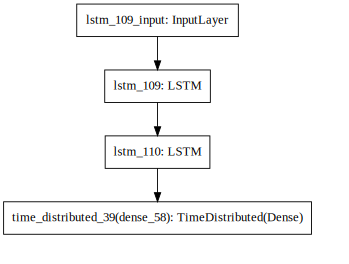

In [286]:
from IPython.display import SVG
from keras.utils import model_to_dot


SVG(model_to_dot(model, dpi=65).create(prog='dot', format='svg'))